# Metodologia de Classificação Climática de Cidades  
**Autor:** John Costa

**Fontes dos Dados:**  
- [Instituto Português do Mar e da Atmosfera (IPMA)](https://www.ipma.pt/)
- [World Weather Online](https://www.worldweatheronline.com/)
- [Open-Meteo](https://open-meteo.com/)
- [Shape Portugal - Natural Earth](https://www.naturalearthdata.com/)

---

## Objetivo

Este documento explica, de forma simples e transparente, como foi realizada a classificação do clima das cidades de Portugal (e exemplos do Brasil), mostrando a lógica utilizada no cálculo do score climático, os critérios para extremos, a metodologia dos índices e as influências dos fatores naturais e humanos no clima. Exemplos reais ilustram cada etapa.

---

## 1. **Elementos e Fatores Climáticos**

### **Elementos do Clima**  
São as características do ambiente que sentimos ou medimos no dia a dia:

- **Temperatura**: grau de calor do ar.
- **Umidade**: quantidade de vapor d’água presente no ar.
- **Pressão atmosférica**: força do ar sobre a superfície.
- **Precipitação**: chuva, neve ou granizo.
- **Ventos**: movimentação do ar.
- **Radiação solar**: energia recebida do Sol.

### **Fatores Climáticos**  
São aspectos que modificam ou influenciam os elementos:

| Fator                | Como influencia a temperatura e outros elementos                       | Exemplo prático                         |
|----------------------|-----------------------------------------------------------------------|-----------------------------------------|
| **Latitude**         | Próximo ao Equador = mais quente; longe = mais frio                   | Algarve mais quente que Porto           |
| **Altitude/Relevo**  | Locais altos = mais frio                                              | Serra da Estrela com neve               |
| **Maritimidade**     | Próximo ao mar = menos variação térmica                               | Lisboa com invernos mais amenos         |
| **Continentalidade** | Interior = maior variação entre verão e inverno                       | Interior do Alentejo mais extremo       |
| **Correntes Marítimas** | Correntes frias/quentes afetam temperatura do litoral               | Corrente do Golfo suaviza litoral oeste |
| **Uso/Ocupação do Solo** | Cidades são mais quentes (ilhas de calor), menos vegetação         | Centro de Lisboa mais quente            |

---

## 2. **Aparelhos de Medição Climática**

- **Termômetro**: mede temperatura do ar.
- **Pluviómetro**: mede a quantidade de chuva (mm).
- **Higrômetro**: mede a umidade relativa do ar.
- **Barômetro**: mede a pressão atmosférica.
- **Anemômetro**: mede a velocidade dos ventos.
- **Heliógrafo**: mede horas de sol.
- **Biruta**: indica a direção do vento.

As medições são realizadas em estações meteorológicas espalhadas nas cidades.

---

## 3. **Metodologia de Classificação**

### **a) Identificação de Eventos Extremos**

Um dia é considerado extremo se atender ao menos um dos critérios abaixo:
- **Calor extremo**: máxima > 35°C ou Heat Index > 40°C
- **Frio extremo**: mínima < -3°C ou Wind Chill < -5°C
- **Chuva extrema**: precipitação diária acima de 30 mm *(ajustado para a média portuguesa)*
- **Neve**: qualquer valor positivo em Portugal continental
- **UV extremo**: índice ≥ 8

### **b) Cálculo do "Clima Típico"**

- Remove dias extremos do cálculo das médias anuais de cada variável.
- Calcula as médias dos elementos climáticos principais: máxima, mínima, sensação térmica, umidade, chuva, sol e UV.

### **c) Score de Conforto Climático**

#### **Ponderação**
O score parte de 100 e utiliza média dos dias "típicos" (sem extremos):

- Temperatura máxima ideal (22 a 28°C): 60%
- Umidade (30-80%): 15%
- Sol (≥ 5h/dia): 15%
- Precipitação (≤ 20mm/dia): 10%

*Se a máxima anual for muito baixa (≤ 21°C), a pontuação máxima na temperatura cai, refletindo clima considerado frio para conforto.*

#### **Penalização por Extremos**
- Calor extremo: -0,3 ponto por dia
- Frio extremo: -0,4 ponto por dia
- Chuva extrema: -0,2 ponto por dia
- Penalização máxima limitada a 20 pontos

### **d) Classificação Final**

| Score         | Classificação |
|---------------|--------------|
| ≥ 80          | Excelente    |
| 70 a 79,99    | Muito Bom    |
| 60 a 69,99    | Bom          |
| 50 a 59,99    | Aceitável    |
| < 50          | Marginal     |

---

## 4. **Exemplo de Aplicação**

### **Lisboa**
- Máxima média: 25,6°C
- Mínima média: 15,8°C
- Umidade: 69%
- Chuva: 1,9 mm/dia
- Dias extremos: 2 de calor, 0 de frio, 2 de chuva
- **Score:** 88,4 → **Classificação: Excelente**

### **Porto**
- Máxima média: 22,8°C
- Mínima média: 12,5°C
- Umidade: 74%
- Chuva: 2,8 mm/dia
- Dias extremos: 0 de calor, 0 de frio, 3 de chuva
- **Score:** 81,2 → **Classificação: Excelente**

### **São Paulo (Brasil)**
- Máxima média: 28,3°C
- Mínima média: 16,9°C
- Umidade: 64%
- Chuva: 2,0 mm/dia
- Dias extremos: 9 de calor, 0 de frio, 23 de chuva
- **Score:** 62,1 → **Classificação: Bom**

---

## 5. **Visualização no Mapa**

Cada cidade foi plotada em um mapa de Portugal, colorida conforme a classificação:
- **Azul**: Excelente / Muito Bom
- **Verde**: Bom
- **Amarelo**: Aceitável
- **Vermelho**: Marginal

<sub>*Sugestão: Utilize bibliotecas como `geopandas` e `matplotlib` para criar o mapa. Veja exemplo de código na documentação técnica.*</sub>

---

## 6. **Considerações**

- Os dados usados são médias diárias, podendo haver limitações para eventos de chuva intensa em curto período.
- Os extremos são baseados em referências de saúde pública e médias portuguesas.
- A metodologia busca um equilíbrio entre conforto humano e variabilidade natural do clima, facilitando comparação entre cidades.

---

## 7. **Referências**

- IPMA - Instituto Português do Mar e da Atmosfera ([site](https://www.ipma.pt/))
- World Weather Online ([site](https://www.worldweatheronline.com/))
- Mieczkowski, Z. (1985). The Tourism Climate Index: A Method of Evaluating World Climates for Tourism.
- Artigos de Meteorologia, sites oficiais de institutos e literatura de conforto climático.


In [ ]:
#!pip install geopandas

In [130]:
import pandas as pd
import numpy as np
import os

# === FUNÇÕES DE DETECÇÃO DE EVENTOS EXTREMOS ===
def is_hot_extreme(row):
    """Evento de calor extremo: Temperatura máxima > 35°C OU Heat Index > 40°C."""
    return row['maxtempC'] > 35 or row['HeatIndexC'] > 40

def is_cold_extreme(row):
    """Evento de frio extremo: Temperatura mínima < -3°C OU Wind Chill < -5°C."""
    return row['mintempC'] < -3 or row['WindChillC'] < -5

def is_rain_extreme(row):
    """Evento de chuva extrema: Precipitação diária > 35 mm."""
    return row['precipMM'] > 35

def is_snow_extreme(row):
    """Evento de neve: Qualquer valor positivo já é extremo em Portugal continental."""
    return row['totalSnow_cm'] > 0

def is_uv_extreme(row):
    """Radiação UV extrema: Índice UV >= 8 (OMS: muito alto)."""
    return row['uvIndex'] >= 8

# === FUNÇÕES AUXILIARES ===
def assign_season(month):
    if month in [12, 1, 2]:
        return 'Inverno'
    elif month in [3, 4, 5]:
        return 'Primavera'
    elif month in [6, 7, 8]:
        return 'Verão'
    else:
        return 'Outono'

def classify_city_index(score):
    if score >= 80:
        return 'Excelente'
    elif score >= 70:
        return 'Muito Bom'
    elif score >= 60:
        return 'Bom'
    elif score >= 50:
        return 'Aceitável'
    else:
        return 'Marginal'

# === CÁLCULO DO TCI - Tourism Climate Index (continua mensal!) ===
def compute_tci_monthly(df):
    df = df.copy()
    df['month'] = df['date_time'].dt.month
    tci_list = []
    for (year, month), dfg in df.groupby([df['date_time'].dt.year, 'month']):
        # ---- CID: conforto diário (temp média)
        tmean = dfg['tempC'].mean()
        rhmean = dfg['humidity'].mean()
        if 20 <= tmean <= 27:
            cid = 10
        elif 16 <= tmean < 20 or 27 < tmean <= 30:
            cid = 7
        elif 13 <= tmean < 16 or 30 < tmean <= 33:
            cid = 5
        elif 10 <= tmean < 13 or 33 < tmean <= 36:
            cid = 3
        else:
            cid = 0
        if rhmean > 90 or rhmean < 30:
            cid -= 1

        # ---- CIA: conforto amplitude diária (temp máxima)
        tmax = dfg['maxtempC'].mean()
        rhmax = dfg['humidity'].mean()
        if 20 <= tmax <= 27:
            cia = 10
        elif 16 <= tmax < 20 or 27 < tmax <= 30:
            cia = 7
        elif 13 <= tmax < 16 or 30 < tmax <= 33:
            cia = 5
        elif 10 <= tmax < 13 or 33 < tmax <= 36:
            cia = 3
        else:
            cia = 0
        if rhmax > 90 or rhmax < 30:
            cia -= 1

        # ---- P: índice de precipitação do mês
        p = dfg['precipMM'].sum()
        if p <= 30:
            pi = 10
        elif p <= 60:
            pi = 7
        elif p <= 90:
            pi = 5
        elif p <= 120:
            pi = 3
        else:
            pi = 0

        # ---- S: insolação média diária
        s = dfg['sunHour'].mean()
        if s >= 9:
            si = 10
        elif s >= 7:
            si = 7
        elif s >= 5:
            si = 5
        elif s >= 3:
            si = 3
        else:
            si = 0

        # ---- W: vento médio no mês
        w = dfg['windspeedKmph'].mean()
        if w < 15:
            wi = 10
        elif w < 25:
            wi = 7
        elif w < 35:
            wi = 5
        elif w < 45:
            wi = 3
        else:
            wi = 0

        tci = 2*cid + 2*cia + 0.5*pi + 0.5*si + wi
        tci = max(0, min(100, tci))
        tci_list.append({'ano': year, 'mes': month, 'tci': tci})

    tci_df = pd.DataFrame(tci_list)
    tci_annual = tci_df['tci'].mean() if not tci_df.empty else np.nan
    return tci_annual, tci_df

# === NOVO: SCORE DIÁRIO E MARCAÇÃO DE EXTREMOS ===
def marcar_extremo(row):
    """Retorna True se houver qualquer evento extremo (calor, frio, chuva, neve)"""
    return (
        is_hot_extreme(row) or
        is_cold_extreme(row) or
        is_rain_extreme(row) or
        is_snow_extreme(row)
    )

def score_dia(row):
    """Calcula score diário usando mesma lógica do score anual"""
    maxtemp = row['maxtempC']
    humidity = row['humidity']
    sun = row['sunHour']
    precip = row['precipMM']

    ideal_temp = 1 if (20 <= maxtemp <= 28) else 0
    moderate_temp = 1 if (18 < maxtemp < 32) else 0
    comfort_temp = 0.7 * ideal_temp + 0.3 * moderate_temp
    comfort_hum = 1 if (30 <= humidity <= 80) else 0
    comfort_sun = 1 if sun >= 5 else 0
    comfort_precip = 1 if precip <= 20 else 0

    penalizacao = 0
    if is_hot_extreme(row): penalizacao += 0.3
    if is_cold_extreme(row): penalizacao += 0.4
    if is_rain_extreme(row): penalizacao += 0.2

    penalizacao = min(penalizacao, 1)
    score = 100 * (0.6 * comfort_temp + 0.15 * comfort_hum + 0.15 * comfort_sun + 0.1 * comfort_precip)
    score -= penalizacao * 20  # Penalização máxima diária: -20
    return max(score, 0)

# Função para classificar score diário
def classifica_score(score):
    if score >= 80:
        return 'Excelente'
    elif score >= 70:
        return 'Muito Bom'
    elif score >= 60:
        return 'Bom'
    elif score >= 50:
        return 'Aceitável'
    else:
        return 'Marginal'

# === LEITURA DE MÚLTIPLOS CSVs DE UMA PASTA (mantida) ===
def load_weather_data(folder_path, min_days=365):
    dfs = []
    arquivos_descartados = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path, parse_dates=['date_time'])
            city_name = filename.split(',')[0].replace("+", " ")
            df['municipio'] = city_name

            num_dias = df['date_time'].nunique()
            periodo = df['date_time'].max() - df['date_time'].min()

            if num_dias >= min_days:
                dfs.append(df)
            else:
                arquivos_descartados.append((filename, num_dias, periodo.days))

    print("\nArquivos descartados (menos de", min_days, "dias de histórico):")
    for nome, dias, periodo in arquivos_descartados:
        print(f"{nome}: {dias} dias distintos, período coberto: {periodo} dias")

    if not dfs:
        print("Nenhum arquivo com histórico suficiente.")
        return pd.DataFrame()

    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df

def formatar_numericos(df):
    for col in df.select_dtypes(include='number').columns:
        df[col] = df[col].apply(lambda x: '{:,.2f}'.format(x).replace(',', 'X').replace('.', ',').replace('X', '.'))
    return df


In [131]:
filePathClima = '..\\..\\Bases\\Clima\\worldWeatherApi\\'
df = load_weather_data(filePathClima)


Arquivos descartados (menos de 365 dias de histórico):


In [132]:
filePathMunicipios = '..\\..\\Bases\\Municipios\\portugalMunicipios.csv'
df_municipios =  pd.read_csv(filePathMunicipios)

In [134]:
from unidecode import unidecode

# Padroniza nomes: minúsculas, sem espaços extras e sem acentos
df['location_merge'] = df['municipio'].apply(lambda x: unidecode(str(x)).lower().strip())
df_municipios['Cidades_merge'] = df_municipios['Cidades'].apply(lambda x: unidecode(str(x)).lower().strip())


# Junta pelo nome da cidade padronizado
df = pd.merge(
    df,
    df_municipios,
    left_on='location_merge',
    right_on='Cidades_merge',
    how='left'
)

In [135]:
n_cidades = df['municipio'].nunique()
print(f"O dataframe possui {n_cidades} cidades diferentes.")

O dataframe possui 309 cidades diferentes.


In [136]:
df_nao_cruzadas = df[df['Regiao'].isna()]
print(df_nao_cruzadas)

Empty DataFrame
Columns: [date_time, maxtempC, mintempC, totalSnow_cm, sunHour, uvIndex, moon_illumination, moonrise, moonset, sunrise, sunset, DewPointC, FeelsLikeC, HeatIndexC, WindChillC, WindGustKmph, cloudcover, humidity, precipMM, pressure, tempC, visibility, winddirDegree, windspeedKmph, location, municipio, location_merge, Unnamed: 0, Regiao, Cidades, Cidades_merge]
Index: []

[0 rows x 31 columns]


In [137]:
nao_cruzadas = df[df['Regiao'].isna()]['municipio'].unique()
print("Cidades que não cruzaram:", nao_cruzadas)

Cidades que não cruzaram: []


In [138]:
# Marcação e score diários:
df['calor_extremo']   = df.apply(is_hot_extreme, axis=1).astype(int)
df['frio_extremo']    = df.apply(is_cold_extreme, axis=1).astype(int)
df['chuva_extrema']   = df.apply(is_rain_extreme, axis=1).astype(int)
df['neve']            = df.apply(is_snow_extreme, axis=1).astype(int)
df['uv_extremo']      = df.apply(is_uv_extreme, axis=1).astype(int)

df['evento_extremo'] = df.apply(marcar_extremo, axis=1)
df['score_dia'] = df.apply(score_dia, axis=1)
df['classificacao_dia'] = df['score_dia'].apply(classifica_score)
df['ano_mes'] = df['date_time'].dt.to_period('M')
df['ano'] = df['date_time'].dt.year
df['estacao'] = df['ano_mes'].apply(lambda x: assign_season(x.month))


In [139]:
df = df[['date_time', 'maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour',
       'uvIndex', 'moon_illumination', 'moonrise', 'moonset', 'sunrise',
       'sunset', 'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC',
       'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure',
       'tempC', 'visibility', 'winddirDegree', 'windspeedKmph', 'location',
       'municipio',  'Regiao', 'calor_extremo', 'frio_extremo', 'chuva_extrema',
       'neve', 'uv_extremo', 'evento_extremo', 'score_dia',
       'classificacao_dia', 'ano_mes', 'ano', 'estacao']]

In [145]:
df[['Regiao','municipio']].drop_duplicates()

,Regiao,municipio
0,Centro,Abrantes
366,Centro,Agueda
732,Centro,Aguiar da Beira
1098,Alentejo,Alandroal
1464,Centro,Albergaria-a-Velha
...,...,...
111264,Norte,Vimioso
111630,Norte,Vinhais
111996,Centro,Viseu
112362,Norte,Vizela


In [147]:
df[df['Regiao'].isnull() | (df['Regiao'].astype(str).str.strip() == '')]

,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,sunrise,...,frio_extremo,chuva_extrema,neve,uv_extremo,evento_extremo,score_dia,classificacao_dia,ano_mes,ano,estacao


In [149]:

# Resumo Geral
resumo_mensal = df.groupby(['Regiao','municipio', 'ano_mes','estacao']).agg(
    dias_no_mes = ('classificacao_dia', 'count'),
    dias_bons = ('classificacao_dia', lambda x: (x.isin(['Excelente','Muito Bom','Bom'])).sum()),
    dias_aceitaveis = ('classificacao_dia', lambda x: (x == 'Aceitável').sum()),
    dias_marginais = ('classificacao_dia', lambda x: (x == 'Marginal').sum()),
    extremos = ('evento_extremo', 'sum'),
    percentual_extremos = ('evento_extremo', lambda x: 100*x.sum()/len(x)),
    media_score = ('score_dia', 'mean'),
    score_max = ('score_dia', 'max'),
    score_min = ('score_dia', 'min'),
    score_std = ('score_dia', 'std'),
    media_maxtemp = ('maxtempC', 'mean'),
    maxtemp_max = ('maxtempC', 'max'),
    media_mintemp = ('mintempC', 'mean'),
    mintemp_min = ('mintempC', 'min'),
    media_totalSnow_cm = ('totalSnow_cm', 'mean'),
    media_sunHour = ('sunHour', 'mean'),
    media_uvIndex = ('uvIndex', 'mean'),
    media_FeelsLikeC = ('FeelsLikeC', 'mean'),
    media_HeatIndexC = ('HeatIndexC', 'mean'),
    media_WindChillC = ('WindChillC', 'mean'),
    media_humidity = ('humidity', 'mean'),
    media_precipMM = ('precipMM', 'mean'),
    media_tempC = ('tempC', 'mean'),
    calor_extremo = ('calor_extremo', 'sum'),
    frio_extremo = ('frio_extremo', 'sum'),
    chuva_extrema = ('chuva_extrema', 'sum'),
    neve = ('neve', 'sum'),
    uv_extremo = ('uv_extremo', 'sum'),
    class_mais_comum = ('classificacao_dia', lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
).reset_index()

resumo_mensal['classificacao_mes'] = resumo_mensal['media_score'].apply(classifica_score)

# resumo geral:
resumo_geral = df.groupby(['Regiao','municipio']).agg(
    total_dias = ('classificacao_dia', 'count'),
    dias_bons = ('classificacao_dia', lambda x: (x.isin(['Excelente','Muito Bom','Bom'])).sum()),
    dias_aceitaveis = ('classificacao_dia', lambda x: (x == 'Aceitável').sum()),
    dias_marginais = ('classificacao_dia', lambda x: (x == 'Marginal').sum()),
    extremos = ('evento_extremo', 'sum'),
    percentual_extremos = ('evento_extremo', lambda x: 100*x.sum()/len(x)),
    calor_extremo = ('calor_extremo', 'sum'),
    frio_extremo = ('frio_extremo', 'sum'),
    chuva_extrema = ('chuva_extrema', 'sum'),
    neve = ('neve', 'sum'),
    uv_extremo = ('uv_extremo', 'sum'),
    media_score = ('score_dia', 'mean'),
    media_maxtemp = ('maxtempC', 'mean'),
    media_mintemp = ('mintempC', 'mean'),
    media_totalSnow_cm = ('totalSnow_cm', 'mean'),
    media_sunHour = ('sunHour', 'mean'),
    media_uvIndex = ('uvIndex', 'mean'),
    media_FeelsLikeC = ('FeelsLikeC', 'mean'),
    media_HeatIndexC = ('HeatIndexC', 'mean'),
    media_WindChillC = ('WindChillC', 'mean'),
    media_humidity = ('humidity', 'mean'),
    media_precipMM = ('precipMM', 'mean'),
    media_tempC = ('tempC', 'mean')
).reset_index()

resumo_geral['classificacao_geral'] = resumo_geral['media_score'].apply(classifica_score)


In [150]:
tci_registros = []

for municipio, dados in df.groupby(['Regiao','municipio']):
    # Calcula TCI mensal e anual
    tci_annual, tci_mensal = compute_tci_monthly(dados)
    # Para cada mês desse município, anote também as médias dos componentes do TCI
    dados['year'] = dados['date_time'].dt.year
    dados['month'] = dados['date_time'].dt.month
    for i, row in tci_mensal.iterrows():
        ano = row['ano']
        mes = row['mes']
        # Seleciona só aquele mês/ano
        dados_mes = dados[(dados['year'] == ano) & (dados['month'] == mes)]
        # Calcula as médias/indicadores do TCI:
        tmean = dados_mes['tempC'].mean()
        rhmean = dados_mes['humidity'].mean()
        tmax = dados_mes['maxtempC'].mean()
        # Se quiser rhmax separado (UR máxima), coloque aqui, mas no seu código estava usando média:
        rhmax = dados_mes['humidity'].mean()
        precip = dados_mes['precipMM'].sum()
        sun = dados_mes['sunHour'].mean()
        wind = dados_mes['windspeedKmph'].mean()
        # Monta registro
        reg = {
            'municipio': municipio,
            'ano': ano,
            'mes': mes,
            'tci': row['tci'],
            'tci_anual': tci_annual,
            'tempC_media': tmean,
            'humidity_media': rhmean,
            'maxtempC_media': tmax,
            'humidity_max_media': rhmax,  # Aqui está igual ao rhmean, pode mudar se quiser pegar o valor máximo.
            'precipMM_total': precip,
            'sunHour_media': sun,
            'windspeedKmph_media': wind
        }
        tci_registros.append(reg)

# Junta tudo em um DataFrame
tci_df = pd.DataFrame(tci_registros)

# Se quiser, pode reordenar as colunas
colunas = [
    'municipio', 'ano', 'mes', 'tci', 'tci_anual',
    'tempC_media', 'humidity_media', 'maxtempC_media', 'humidity_max_media',
    'precipMM_total', 'sunHour_media', 'windspeedKmph_media'
]
tci_df = tci_df[colunas]

print(tci_df.head())


               municipio     ano   mes   tci  tci_anual  tempC_media  \
0  (Alentejo, Alandroal)  2024.0   6.0  57.0  41.384615    26.000000   
1  (Alentejo, Alandroal)  2024.0   7.0  32.0  41.384615    34.645161   
2  (Alentejo, Alandroal)  2024.0   8.0  32.0  41.384615    35.419355   
3  (Alentejo, Alandroal)  2024.0   9.0  48.0  41.384615    28.866667   
4  (Alentejo, Alandroal)  2024.0  10.0  53.5  41.384615    22.612903   

   humidity_media  maxtempC_media  humidity_max_media  precipMM_total  \
0       61.000000       26.000000           61.000000             0.6   
1       46.935484       34.645161           46.935484             1.7   
2       46.612903       35.419355           46.612903             0.0   
3       53.433333       28.866667           53.433333            13.4   
4       73.193548       22.612903           73.193548           123.3   

   sunHour_media  windspeedKmph_media  
0       9.000000            16.000000  
1      13.709677            13.354839  
2      1

In [152]:
# Salva Ranking Base
filePathRankingBase = '..\\..\\Bases\\Clima\\worldWeatherApi\\ranking\\ranking_base.csv'

df_formatado = formatar_numericos(df)

df_formatado.to_csv(filePathRankingBase, index=False)

del(df_formatado)

In [153]:
# Salva Ranking Mensal
filePathRankingMensal = '..\\..\\Bases\\Clima\\worldWeatherApi\\ranking\\ranking_Mensal.csv'
resumo_mensal_formatado = formatar_numericos(resumo_mensal)
resumo_mensal_formatado.to_csv(filePathRankingMensal, index=False)
del(resumo_mensal_formatado)

In [154]:
# Salva Ranking Geral
filePathRankingGeral = '..\\..\\Bases\\Clima\\worldWeatherApi\\ranking\\ranking_Geral.csv'
resumo_geral_formatado = formatar_numericos(resumo_geral)
resumo_geral_formatado.to_csv(filePathRankingGeral, index=False)
del(resumo_geral_formatado)

In [155]:
# Salva Ranking TCI
filePathRankingTCI = '..\\..\\Bases\\Clima\\worldWeatherApi\\ranking\\ranking_TCI.csv'
resumo_TCI_formatado = formatar_numericos(tci_df)
resumo_TCI_formatado.to_csv(filePathRankingTCI, index=False)
del(resumo_TCI_formatado)

In [168]:
for col in ['media_score', 'media_maxtemp', 'media_mintemp', 'extremos']:
    resumo_geral[col] = (
        resumo_geral[col]
        .astype(str)
        .str.replace(',', '.', regex=False)  # Caso venha com vírgula no lugar do ponto
        .astype(float)
    )
    
top10 = resumo_geral.sort_values('media_score', ascending=False).head(100)

texto = "🏆 Top 10 cidades com melhor score climático 🏆\n"
for i, row in enumerate(top10.itertuples(), 1):
    texto += (f"{i:02d}. {row.municipio}: {row.media_score:.1f} pontos | "
              f"Extremos: {row.extremos} | "
              f"Máx: {row.media_maxtemp:.1f}°C | "
              f"Mín: {row.media_mintemp:.1f}°C\n")
print(texto)

🏆 Top 10 cidades com melhor score climático 🏆
01. Santa Cruz: 71.9 pontos | Extremos: 3.0 | Máx: 20.9°C | Mín: 16.9°C
02. Machico: 71.9 pontos | Extremos: 3.0 | Máx: 20.9°C | Mín: 16.9°C
03. Avis: 71.5 pontos | Extremos: 1.0 | Máx: 26.6°C | Mín: 13.5°C
04. sao paulo: 70.9 pontos | Extremos: 14.0 | Máx: 28.3°C | Mín: 17.1°C
05. Porto Santo: 69.5 pontos | Extremos: 1.0 | Máx: 20.1°C | Mín: 19.2°C
06. Faro: 66.5 pontos | Extremos: 2.0 | Máx: 21.1°C | Mín: 15.7°C
07. Belmonte: 66.3 pontos | Extremos: 2.0 | Máx: 21.2°C | Mín: 15.6°C
08. Lagos: 66.2 pontos | Extremos: 1.0 | Máx: 20.7°C | Mín: 14.7°C
09. Olhao: 65.9 pontos | Extremos: 2.0 | Máx: 21.2°C | Mín: 15.6°C
10. Oeiras: 64.8 pontos | Extremos: 5.0 | Máx: 20.3°C | Mín: 14.4°C
11. Almada: 64.1 pontos | Extremos: 3.0 | Máx: 21.6°C | Mín: 13.9°C
12. Barreiro: 64.1 pontos | Extremos: 3.0 | Máx: 21.6°C | Mín: 13.9°C
13. Lisboa: 63.9 pontos | Extremos: 5.0 | Máx: 21.2°C | Mín: 14.0°C
14. Odivelas: 63.9 pontos | Extremos: 5.0 | Máx: 21.2°C | 

In [169]:
for col in ['media_score', 'media_maxtemp', 'media_mintemp', 'extremos']:
    resumo_mensal[col] = (
        resumo_mensal[col]
        .astype(str)
        .str.replace(',', '.', regex=False)
        .astype(float)
    )

for estacao in ['Verão', 'Outono', 'Primavera', 'Inverno']:
    print(f"\n🏅 Top 10 cidades - {estacao} 🏅")
    # Seleciona o melhor mês de cada cidade na estação (pelo maior score)
    top_por_cidade = (
        resumo_mensal[resumo_mensal['estacao'] == estacao]
        .sort_values('media_score', ascending=False)
        .groupby('municipio', as_index=False)
        .first()
    )
    # Agora pega só os 10 melhores
    top10 = top_por_cidade.sort_values('media_score', ascending=False).head(10)
    for i, row in enumerate(top10.itertuples(), 1):
        print(f"{i:02d}. {row.municipio}: {row.media_score:.1f} pontos | Extremos: {row.extremos} | Máx: {row.media_maxtemp:.1f}°C | Mín: {row.media_mintemp:.1f}°C | {row.classificacao_mes} | {row.ano_mes}")



🏅 Top 10 cidades - Verão 🏅
01. Abrantes: 100.0 pontos | Extremos: 0.0 | Máx: 24.0°C | Mín: 15.0°C | Excelente | 2024-06
02. Penedono: 100.0 pontos | Extremos: 0.0 | Máx: 21.0°C | Mín: 13.0°C | Excelente | 2024-06
03. Ponta Delgada: 100.0 pontos | Extremos: 0.0 | Máx: 22.0°C | Mín: 20.0°C | Excelente | 2024-06
04. Pombal: 100.0 pontos | Extremos: 0.0 | Máx: 23.0°C | Mín: 14.0°C | Excelente | 2024-06
05. Pinhel: 100.0 pontos | Extremos: 0.0 | Máx: 20.0°C | Mín: 10.0°C | Excelente | 2024-06
06. Peso da Regua: 100.0 pontos | Extremos: 0.0 | Máx: 21.0°C | Mín: 13.0°C | Excelente | 2024-06
07. Peniche: 100.0 pontos | Extremos: 0.0 | Máx: 21.0°C | Mín: 16.0°C | Excelente | 2024-06
08. Penela: 100.0 pontos | Extremos: 0.0 | Máx: 22.0°C | Mín: 13.0°C | Excelente | 2024-06
09. Penamacor: 100.0 pontos | Extremos: 0.0 | Máx: 23.0°C | Mín: 11.0°C | Excelente | 2024-06
10. Ponte da Barca: 100.0 pontos | Extremos: 0.0 | Máx: 22.0°C | Mín: 14.0°C | Excelente | 2024-06

🏅 Top 10 cidades - Outono 🏅
01.

In [166]:
# Garante que os campos estão corretos para ordenação
for col in ['media_score', 'media_maxtemp', 'media_mintemp', 'extremos']:
    resumo_mensal[col] = (
        resumo_mensal[col]
        .astype(str)
        .str.replace(',', '.', regex=False)
        .astype(float)
    )

# Define ordem das classificações
ordem_classificacao = ['Excelente', 'Muito Bom', 'Bom', 'Aceitável', 'Marginal']

texto = '🏆 Lista de cidades agrupadas por classificação 🏆\n'
for classificacao in ordem_classificacao:
    grupo = resumo_mensal[resumo_mensal['classificacao_mes'] == classificacao]\
        .sort_values('media_score', ascending=False)
    if not grupo.empty:
        texto += f"\n🔹 {classificacao}:\n"
        for idx, row in grupo.iterrows():
            texto += (
                f"   - [{row['Regiao']}] {row['municipio']} ({row['ano_mes']}): "
                f"{row['media_score']:.1f} pontos | "
                f"Extremos: {row['extremos']} | "
                f"Máx: {row['media_maxtemp']:.1f}°C | "
                f"Mín: {row['media_mintemp']:.1f}°C\n"
            )

print(texto)


🏆 Lista de cidades agrupadas por classificação 🏆

🔹 Excelente:
   - [Alentejo] Alandroal (2024-06): 100.0 pontos | Extremos: 0.0 | Máx: 26.0°C | Mín: 14.0°C
   - [Centro] Celorico da Beira (2024-06): 100.0 pontos | Extremos: 0.0 | Máx: 20.0°C | Mín: 10.0°C
   - [Centro] Covilha (2024-06): 100.0 pontos | Extremos: 0.0 | Máx: 23.0°C | Mín: 11.0°C
   - [Norte] Tabuaco (2024-06): 100.0 pontos | Extremos: 0.0 | Máx: 21.0°C | Mín: 13.0°C
   - [Centro] Constancia (2024-06): 100.0 pontos | Extremos: 0.0 | Máx: 24.0°C | Mín: 15.0°C
   - [Norte] Tarouca (2024-06): 100.0 pontos | Extremos: 0.0 | Máx: 21.0°C | Mín: 13.0°C
   - [Centro] Condeixa-a-Nova (2024-06): 100.0 pontos | Extremos: 0.0 | Máx: 22.0°C | Mín: 13.0°C
   - [Norte] Terras de Bouro (2024-06): 100.0 pontos | Extremos: 0.0 | Máx: 22.0°C | Mín: 14.0°C
   - [Centro] Coimbra (2024-06): 100.0 pontos | Extremos: 0.0 | Máx: 22.0°C | Mín: 13.0°C
   - [Norte] Torre de Moncorvo (2024-06): 100.0 pontos | Extremos: 0.0 | Máx: 21.0°C | Mín: 13.0°

In [160]:
filePathGeo = '..\\..\\Bases\\Geocoding\\portugalMunicipiosGeo.csv'
# Carrega o arquivo de coordenadas
geo = pd.read_csv(filePathGeo)


In [161]:
# Padroniza nomes para garantir o merge
resumo_geral['location_merge'] = resumo_geral['municipio'].apply(lambda x: unidecode(str(x)).lower().strip())
geo['Cidades_merge'] = geo['Cidades'].apply(lambda x: unidecode(str(x)).lower().strip())

# Junta pelo nome da cidade padronizado
resumo_geral_geo = pd.merge(
    resumo_geral,
    geo,
    left_on='location_merge',
    right_on='Cidades_merge',
    how='inner'
)

C:\Users\johns\AppData\Local\Temp\ipykernel_27852\1267252002.py:20: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  portugal_union = portugal.geometry.unary_union


Todas as cidades estão corretamente localizadas em Portugal.


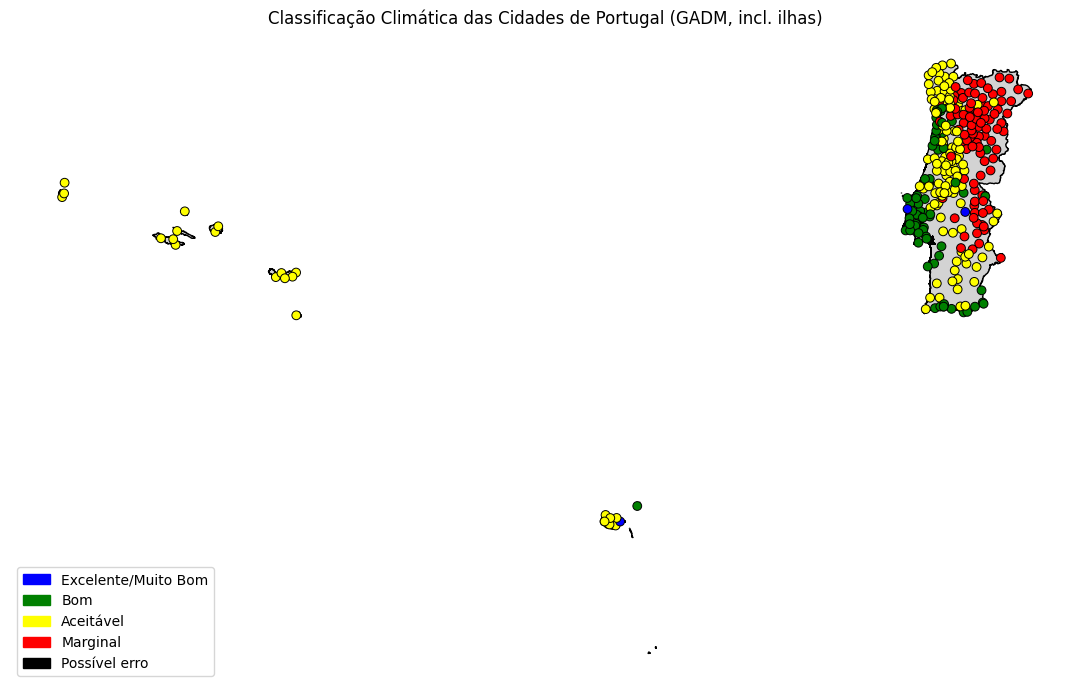

In [162]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Caminho do shapefile do GADM (Portugal)

shapefile_path = '..\\..\\Bases\\Geocoding\\files\\Gadm - Portugal - Shape\\gadm41_PRT_0.shp' 
# 1. Carrega e limpa o shapefile
portugal = gpd.read_file(shapefile_path)

# Corrige eventuais geometrias inválidas
portugal['geometry'] = portugal['geometry'].buffer(0)
# Remove linhas sem geometria válida
portugal = portugal[portugal.is_valid & ~portugal.is_empty]

if portugal.empty:
    raise ValueError('O shapefile está vazio ou inválido!')

# Faz a união de todos os polígonos do shape (Continente + Madeira + Açores)
portugal_union = portugal.geometry.unary_union

# 2. Converte sua tabela de cidades para GeoDataFrame
# ranking_geo deve ter as colunas 'municipio', 'latitude', 'longitude', 'classificacao_geral'
cores = {
    'Excelente': 'blue',
    'Muito Bom': 'blue',
    'Bom': 'green',
    'Aceitável': 'yellow',
    'Marginal': 'red'
}
resumo_geral_geo['cor'] = resumo_geral_geo['classificacao_geral'].map(cores)

gdf = gpd.GeoDataFrame(
    resumo_geral_geo,
    geometry=gpd.points_from_xy(resumo_geral_geo.longitude, resumo_geral_geo.latitude),
    crs="EPSG:4326"
)

# 3. Marque pontos dentro e fora de Portugal (incluindo ilhas)
gdf['dentro_portugal'] = gdf.geometry.apply(portugal_union.covers)

# Separe pontos
dentro_portugal = gdf[gdf['dentro_portugal']]
fora_portugal = gdf[~gdf['dentro_portugal']]

# 4. Mostre os possíveis erros
if not fora_portugal.empty:
    print('Cidades possivelmente com coordenadas erradas:')
    print(fora_portugal[['municipio', 'latitude', 'longitude']])
else:
    print('Todas as cidades estão corretamente localizadas em Portugal.')

# 5. Plot bonito!
fig, ax = plt.subplots(figsize=(11, 13))
portugal.plot(ax=ax, color='lightgrey', edgecolor='black', zorder=0)
dentro_portugal.plot(
    ax=ax, color=dentro_portugal['cor'], markersize=40,
    marker='o', edgecolor='black', linewidth=0.7, zorder=2
)
if not fora_portugal.empty:
    fora_portugal.plot(
        ax=ax, color='black', markersize=70, marker='x',
        label='Possível erro', zorder=3
    )

patches = [
    mpatches.Patch(color='blue', label='Excelente/Muito Bom'),
    mpatches.Patch(color='green', label='Bom'),
    mpatches.Patch(color='yellow', label='Aceitável'),
    mpatches.Patch(color='red', label='Marginal'),
    mpatches.Patch(color='black', label='Possível erro')
]
plt.legend(handles=patches, loc='lower left', fontsize=10)
plt.title('Classificação Climática das Cidades de Portugal (GADM, incl. ilhas)')
plt.axis('off')
plt.tight_layout()
plt.show()